https://www.youtube.com/watch?v=TCH_1BHY58I
지난 makemore는 바로 직전의 글자만 보니까 성능이 안좋을만 했다.
length of context에 따라 표의 사이즈가 커져버린다.(27*27) -> (27*27 x 27*27) -> ( 27*27*27 x 27*27*27 )
이제 MLP, (multilayer perceptron) 모델
우리는 아직 character level language model이지만, 위 논문에서는 17000개의 vocabulary를 기준으로 한 word level language model. (종합해서 17000개의 단어가 등장한 문서들)

17000개의 단어를 30개의 vector로 임베딩해보려 한 것.
처음에는 random하게 split되어 있다가, similar 한 단어들은 비슷한 공간으로 모이도록 설계한다. 
maximize the log-likelihood of the training data가 목적이다.

A dog was running in a room 이란 문장을 못봤으면
A dog was running in a 다음에 뭐가나올지 모르는데, embedding space의 transfer 된 knowledge를 통해 이걸 유추해내길 바란다.

3개의 이전 단어들을 보고, 다음 단어를 보고 싶어한다.
각 단어들은 17000 단어중 몇번째에 속하는지 index정보만 갖고있으면 돼. (one hot encoded 처럼)
그래서 lookup table을 보고, 각 단어가 어떤 30dimension vector에 속하는지 확인할것이다. 

hyper parameter라고 hidden layer를 뒀는데, 100개의 neuron을 둔다고 하면, 
input이 3개 단어 - 100개 뉴런을 거쳐서 - 17000개의 뉴런으로 fully connected 되어서 output은 그중 제일 높은것. 이 되는 형태.

17000 logit이 존재하는것이다. 그래서 exp() 하고 sum()으로 normalize됨. 
우리는 각각에 label이 존재. A dog was 면 running이 다음에 나와야 한다. -> 이 확률을 maximize한다.

output layer, embedding lookup table, hidden layer wieght - 같은 것들이 고쳐진다.


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [1]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [58]:
# build the dataset

block_size=3 # context length : ngram 몇개 선택할것인가. ( 몇개의 단어로 다음 단어 예측할지)
X, Y = [], []
#for w in words[:5]:
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context) # 첫 context는 ... (즉 앞 3글자가 .인거)
        Y.append(ix)
        # print("".join(itos[i] for i in context), '--->',itos[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [59]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
#---------- training dataset set 끝
#---------- embedding 시작

In [10]:
# 우리는 27개야. 17000개를 30개로 embed했었는데, 우리는 2개로 해볼까
C = torch.randn((27,2))
print(C[5])

tensor([ 1.4417, -1.4135])


In [12]:
print(F.one_hot(torch.tensor(5), num_classes=27)) # 27개의 단어를 가진 1 hot encoded.
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # 이걸하면 C[5]가 나오지않나? 5번째 축이랑 곱해지는.

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])


tensor([ 1.4417, -1.4135])

In [14]:
# 우리는 다시 트레이닝set X를 어떻게 embed할지 생각해야한다.
# [a],[b],[c] 가 있는데 각각 [a]-> (0.2,0.1) 이런식으로 되면 좋을거아냐
print(C[[5,6,7]])
print(C[torch.tensor([5,6,7,7,7])])
# 이렇게 tensor를 넣어서 임베딩된 벡터를 얻을 수 있다.
C[X].shape

tensor([[ 1.4417, -1.4135],
        [ 0.6951,  0.8357],
        [-1.6309,  0.7189]])
tensor([[ 1.4417, -1.4135],
        [ 0.6951,  0.8357],
        [-1.6309,  0.7189],
        [-1.6309,  0.7189],
        [-1.6309,  0.7189]])


torch.Size([32, 3, 2])

In [15]:
X[13,2] # 13번째 training set의 2번째 char 

tensor(1)

In [16]:
C[X][13,2] # 하면 13번째 training set의 2번째 char이 embed된 형태

tensor([0.8826, 0.9870])

In [17]:
emb = C[X]

In [29]:
W1 = torch.randn((6,100)) # 우리는 3개 단어에서 2개의 input씩을 받으니 첫 layer는 6개를 input으로 받는다. # 100은 그냥 임의로 잡아보자. 100개의 output이 생성된다.
b1 = torch.randn(100) # 100개의 output 생성될때 더해줘야함.

In [20]:
# emb @ W1 + b1  이걸 하고 싶은데, [32,3,2] 짜리를 [6,100] 에 곱할 수 없다. concatenate을 해야한다. [32,6]으로.
# torch에 cat이 있다. concatenate tensors in the given dimension
print([emb[:,0,:].shape, emb[:,1,:].shape, emb[:,2,:].shape]) # 각 첫번째 단어의 임베딩, 2번째, 3번째
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape # 그치만 이렇게하면, ngram을 3개로 할때만 이렇게 수동으로 indexing한걸로 된다. 그러니까 unbind를 사용하자

[torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2])]


torch.Size([32, 6])

In [24]:
# torch.unbind 를 하면 해당 dimension을 제거해서 펴준다.
print(len(torch.unbind(emb,1))) # 이게 길이가 3인 이유는 (32,3,2) 에서 3을 가진 dimension이 사라져서 (32,2) (32,2) (32,2) 로 출력된다. 즉 위에랑 같은 형태
torch.cat(torch.unbind(emb,1),1).shape

3


torch.Size([32, 6])

In [25]:
# 하지만 이것보다 덜복잡한게 있다
a= torch.arange(18)
print(a.shape, a)

torch.Size([18]) tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])


In [26]:
a.view(9,2) #이걸 이렇게 보겠다~ 하면 차례대로 들어간다. 
"""
torch에서 이게 효과적인 이유는 a.storage()라는, underlying storage가 있는데, 1-D array로 가지고 있는것이다. .view()는 그 tensor를 어떻게 interpret하고 싶은지 나타내는거고,
이 함수를 부를땐 아무런 메모리 변화가 없다. storage를 그대로 사용해서. shape, stride, storage offset을 조정해서 우리눈에 어떻게 보이게 하는지 보여주는것이다. 
"""

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [27]:
emb.shape # 이건 [32,3,2] 이지만, 
emb.view(32,6) # 이렇게 flatten되는것은, 2가 stacked up. 되는것.
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1) # elementwise 비교

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [32]:
#torch.cat은 새로운 torch를 만들기 때문에 메모리를 많이 쓴다.
W1 = torch.randn((6,100)) # 우리는 3개 단어에서 2개의 input씩을 받으니 첫 layer는 6개를 input으로 받는다. # 100은 그냥 임의로 잡아보자. 100개의 output이 생성된다.
b1 = torch.randn(100) # 100개의 output 생성될때 더해줘야함.
h= emb.view(-1,6)@W1 +b1 # -1을 넣으면 torch가 dimension 짐작. emb.shape[0] 이랑 같은 32 를 넣게 될것. 32는 우리 training set dependent하니까.
h = torch.tanh(emb.view(-1,6)@W1 +b1) # activation function으로 tanh. 결과값은 -1과 1사이로 바뀐다.


In [33]:
h.shape

torch.Size([32, 100])

In [35]:
#잠시만, emb.view(-1,6)@W1 +b1 하면 우리가 의도한 덧셈 맞나?
(emb.view(-1,6)@W1).shape # [32,100] 인데, 우리가 b에 넣은건 [100]. 그럼 맞게 되겠다. [1,100]으로 변신, [32,100]으로 확장될테니.  


torch.Size([32, 100])

In [36]:
W2 = torch.randn((100, 27)) #이제 최종 layer. 우리는 27 char중 어떤 char이 나올지 보고싶어.
b2 = torch.randn(27)

In [37]:
logits = h @ W2 + b2

In [39]:
logits.shape

torch.Size([32, 27])

In [41]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [43]:
prob.shape , Y.shape # prob중에 제일 높은걸로 추출해내고 싶다.

(torch.Size([32, 27]), torch.Size([32]))

In [44]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [46]:
prob[torch.arange(32), Y] #이러면 각 Y에 해당하는 확률이 나온다

tensor([2.5258e-06, 7.9556e-13, 2.6447e-07, 1.0628e-09, 1.2317e-09, 2.2637e-09,
        8.5990e-02, 7.1638e-10, 2.3880e-03, 1.0127e-03, 1.9726e-06, 4.9898e-13,
        1.5135e-09, 3.7188e-08, 4.5068e-08, 4.9115e-05, 3.6686e-05, 1.2468e-05,
        2.0189e-09, 7.6988e-15, 9.9681e-14, 1.9709e-05, 4.6855e-05, 1.2437e-09,
        9.7900e-05, 1.3152e-06, 1.1413e-12, 2.0060e-08, 2.1746e-16, 3.1348e-07,
        6.4982e-03, 2.0771e-13])

In [47]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(17.4275)

In [48]:
# ------------ one iteration --------------
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

In [97]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27,generator = g)
parameters = [C,W1,b1,W2,b2]

In [98]:
sum(p.nelement() for p in parameters) # 거쳐야 하는 파라미터 수 


3481

In [99]:
for p in parameters:
    p.requires_grad=True

In [100]:
lre = torch.linspace(-3, 0 , 1000) 
lrs = 10**lre # exponential spacing (위에서는 1~0.001까지를 1000으로 나눠서 보여줬는데, 이제 10^-3 ~ 10^0 사이의 learning rate를 가질 수 있게 됐다.


In [105]:
lri=[]
lossi=[]
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))  #32개만으로도 gradient 만들기 충분하다. 
    
    # emb = C[X] # (32, 3,2 )
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean() 
    loss = F.cross_entropy(logits,Y[ix]) # 저 intermediate tensor들을 메모리에 만들지 않아서 좀더 효율적. (backward pass도 simpler) 
    # 1. 메모리 효율적 - 1장에서 tanh backward 구현할때 t 재사용 한 것처럼.
    # 2. logits.exp() 하기 때문에 100.exp() 이런게 nan이 나와. - infinity가 나와서. -floating point니까. 그런데, monotonic한 함수라서, logits+4를 더하고 이렇게 operation을 하던, logits-100하고 operation하던 결과값이 똑같다.
    # 즉, offset을 더하거나 빼도 된다. 그래서 -최대값만큼 한다음 loss를 구한다. (F.cross_entropy에서) 
    #forward pass 끝
    # print(loss)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    #lr =lrs[i]
    lr = 0.1
    for p in parameters:
        # p.data += -0.1 * p.grad # LR은 어떻게 설정하지? , 적절한 speed인지 알 수 있나?  - 0.0001 하면 loss가 간신히 줄어드는걸 볼 수 있어. loss가 explode 하는걸 (up and down) 보면 너무 큰거야. 그러니 이 사이가 적절하다. 
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

print(loss.item()) #하지만 이건 현재 mini batch의 loss를 말한다.


2.800971031188965


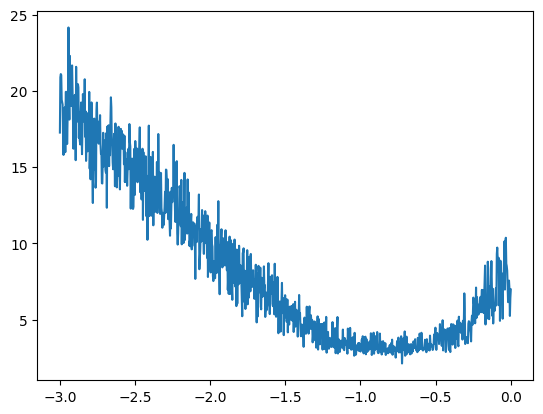

In [102]:
plt.plot(lri,lossi) # loss가 가장 많이 줄어든 건 lr이 조그마할때인거지. 그래서 저 0.1~0.2 사이의 값을 LR로 정해라.

In [94]:
"""
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean() 
이건 그냥 cross_entropy야 
""" 
"""
"""
torch.linspace(0.001,1,1000) # 0.001에서 1 사이의 1000개 변수를 만들어주는데, (차례대로) 
lre = torch.linspace(-3, 0 , 1000) 
lrs = 10**lre # exponential spacing (위에서는 1~0.001까지를 1000으로 나눠서 보여줬는데, 이제 10^-3 ~ 10^0 사이의 learning rate를 가질 수 있게 됐다.
# 처음엔 LR이 굉장히 낮은데, 점점 lr이 올라간다.

In [95]:
"""
mini batch 를 사용해서 training 빠르게 하고 싶어.
"""
torch.randint(0,5,(32,)) #0,5 사이 32개벡터.
torch.randint(0,X.shape[0],(32,)) # 0~트레이닝데이터 개수 사이 32개 숫자. 그래서 32개의 sample에 대해 minibatch 하고 싶다.


tensor([176927, 202813, 100806, 141791, 133341, 120640, 164094,  85599,  65642,
        165891,  38160, 148516,  41927, 209104,  44902, 135554, 202313,  60052,
        212387,  34777, 138330, 214852, 113296, 113300, 214164, 159382, 173661,
        114077,  83341, 171433, 147957,   2506])

In [106]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @W1 + b1)  # (32,100)
logits = h@W2 + b2 # 32,27
loss = F.cross_entropy(logits,Y)
print(loss)

tensor(2.5650, grad_fn=<NllLossBackward0>)


In [ ]:
"""
overfitting 때문에 loss가 좋은 결과가 아닌경우도 있다.
dataset을 그래서 보통 나누는데
training split, dev/validation split, test split 으로 나눈다.
# 80%, 10%, 10%
test split으로 performance측정한다. 
test split은 training 에 매우 적게 들어가야 한다.

"""

In [108]:
def build_dataset(words):
    # build the dataset

    block_size=3 # context length : ngram 몇개 선택할것인가. ( 몇개의 단어로 다음 단어 예측할지)
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # 첫 context는 ... (즉 앞 3글자가 .인거)
            Y.append(ix)
            # print("".join(itos[i] for i in context), '--->',itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [110]:
len(words), n1, n2, n2-n1, len(words) -n2 

(32033, 25626, 28829, 3203, 3204)

In [142]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27,generator = g)
parameters = [C,W1,b1,W2,b2]

In [143]:
for p in parameters:
    p.requires_grad=True

In [146]:
lri=[]
lossi=[]
stepi = []


In [163]:

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  #32개만으로도 gradient 만들기 충분하다. 
    
    # emb = C[X] # (32, 3,2 )
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits,Ytr[ix]) # 저 intermediate tensor들을 메모리에 만들지 않아서 좀더 효율적. (backward pass도 simpler) 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    
    #lr =lrs[i]
    lr = 0.1 if i< 100000 else 0.01
    for p in parameters:
        # p.data += -0.1 * p.grad # LR은 어떻게 설정하지? , 적절한 speed인지 알 수 있나?  - 0.0001 하면 loss가 간신히 줄어드는걸 볼 수 있어. loss가 explode 하는걸 (up and down) 보면 너무 큰거야. 그러니 이 사이가 적절하다. 
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item()) #하지만 이건 현재 mini batch의 loss를 말한다.


2.053797721862793


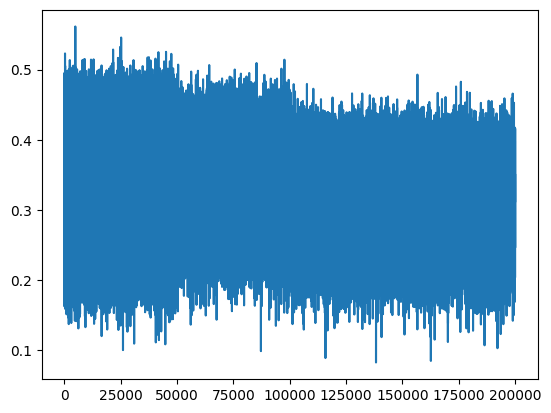

In [164]:
plt.plot(stepi,lossi)

In [ ]:
"문제가 될 수 있는 부분은 세곳. embedding, hidden layer, 마지막 fully connected layer."

In [165]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @W1 + b1)  # (32,100)
logits = h@W2 + b2 # 32,27
loss = F.cross_entropy(logits,Ytr)
print(loss)

tensor(2.0588, grad_fn=<NllLossBackward0>)


In [166]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @W1 + b1)  # (32,100)
logits = h@W2 + b2 # 32,27
loss = F.cross_entropy(logits,Ydev)
print(loss)

tensor(2.1199, grad_fn=<NllLossBackward0>)


In [ ]:
#training loss랑 dev loss가 비슷한거 보면, underfitting이야. 

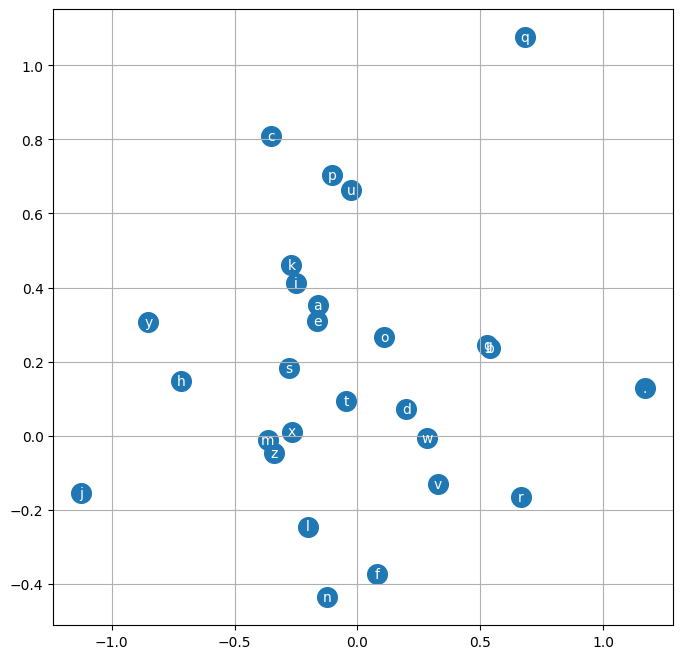

In [151]:
""" 
embedding이 어떻게 되어있는지 볼까.
"""
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [167]:
g= torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out= []
    context = [0] * block_size # 모두 시작은 '...'
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix ==0:
            break
        
    print("".join(itos[i] for i in out))

carlaizabelle.
khi.
mili.
taty.
skaassie.
mahutn.
delynn.
jarqui.
nellara.
chaiir.
kaleigh.
ham.
join.
quint.
sulie.
alianni.
watell.
dearynn.
jace.
pirudie.
